# Viewing basis functions using pyEXP
This example uses the Better example in the EXP/examples directory and assumes that you have run the simulation using EXP.  Easily adapted for other circumstances.

We begin by including the usual header material.  Then point at your desired working directory.  This example uses the data directory in the `EXP_examples/Nbody` repo.

In [1]:
import os
import yaml
import time
import pyEXP
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/home/weinberg/Projects/EXP-examples/Nbody/data')

## Making the biorthogonal basis instances for the halo and disk
Every basis needs a YAML.  These are copied directly from the EXP YAML config file for the halo and disk.

In [2]:
# Make the halo basis config
halo_config="""
---
id: sphereSL
parameters :
  numr:  4000
  rmin:  0.0001
  rmax:  1.95
  Lmax:  4
  nmax:  10
  cmap:  1
  rmapping:  0.0667
  modelname: SLGridSph.model
  cachename: SLGridSph.cache.run0
...
"""

# Make the disk basis config
#
disk_config = """
---
id: cylinder
parameters:
  acyl: 0.01
  hcyl: 0.002
  lmaxfid: 32
  mmax: 6
  nmaxfid: 32
  nmax: 12
  ncylnx: 128
  ncylny: 64
  rcylmax: 20
  ncylodd: 3
  ncylr: 2000
  rnum: 200
  pnum: 0
  tnum: 80
  ashift: 0.5
  vflag: 0
  logr: false
  eof_file: .eof.cache.run0
...
"""

Now we can construct the two basis instances from those config.

In [3]:
# Construct the basis instances
#
halo_basis = pyEXP.basis.Basis.factory(halo_config)
disk_basis = pyEXP.basis.Basis.factory(disk_config)

---- SLGridSph::ReadH5Cache: successfully read basis cache <SLGridSph.cache.run0>
SphericalSL: biorthogonal check passed
---- EmpCylSL::ReadH5Cache: read <.eof.cache.run0>
---- EmpCylSL::read_cache: table forwarded to all processes
Cylindrical: biorthogonal check passed


## What is the orthogonality condition for each basis?

We use the `orthoCheck()` members for each basis to get the Gram matrices for the biorthgonal scalar product and find the maximum error for each:

In [4]:
# Get the orthogoality matrices for each basis type
ortho_halo = halo_basis.orthoCheck(2000)
ortho_disk = disk_basis.orthoCheck()

# Make a table of worst orthgonal checks per harmonic order
def report(ortho):
    for l in range(len(ortho)):
        mat = ortho[l]
        worst = 0.0
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                if i==j: test = np.abs(1.0 - mat[i, j])
                else:    test = np.abs(mat[i, j])
                if test > worst: worst = test
        print('{:4d}  {:13.6e}'.format(l, worst))

# Print the results
#
print("Halo ortho check")
form = '{:>4s}  {:>13s}'
print(form.format('l', 'error'))
print(form.format('-', '-----'))
report(ortho_halo)

print("\nDisk ortho check")
print(form.format('l', 'error'))
print(form.format('-', '-----'))
report(ortho_disk)

Halo ortho check
   l          error
   -          -----
   0   2.060133e-05
   1   2.486114e-05
   2   2.987211e-05
   3   3.444037e-05
   4   3.874714e-05

Disk ortho check
   l          error
   -          -----
   0   4.062153e-03
   1   9.949529e-04
   2   5.380967e-04
   3   1.472111e-04
   4   7.610323e-05
   5   8.727387e-05
   6   9.085380e-05


## Look into the cache file

We can ask for the parameters for any saved basis cache file using the `cacheInfo` member.  The return values are string pairs that can be used for making or adjusting configuration stanzas.  For example:

In [5]:
node_sph = halo_basis.cacheInfo('SLGridSph.cache.run0')
node_cyl = disk_basis.cacheInfo('.eof.cache.run0')

------------------------------------------------------------
Cache parameters for SLGridSph: SLGridSph.cache.run0
------------------------------------------------------------
model               : SLGridSph.model
lmax                : 4
nmax                : 10
numr                : 4000
cmap                : 1
rmin                : 0.0001
rmax                : 1.95
rmapping            : 0.066699999999999995
diverge             : 0
dfac                : 1
------------------------------------------------------------
------------------------------------------------------------
Cache parameters for EmpCylSL: .eof.cache.run0
------------------------------------------------------------
mmax                : 6
numx                : 128
numy                : 64
nmaxfid             : 32
nmax                : 12
neven               : 9
nodd                : 3
cmapr               : 1
cmapz               : 1
rmin                : 0.001
rmax                : 20
ascl                : 0.01
hscl     

## Viewing some basis functions
The `getBasis` member for each basis returns a vectors of arrays for the basis functions on the grid you have defined.  See the following examples.

In [6]:
# Get the two basis grids
#
lrmin = -3.0
lrmax = 0.5
rnum  = 200
halo_grid = halo_basis.getBasis(lrmin, lrmax, rnum)

Rmin = 0.0
Rmax = 0.1
Rnum = 100
Zmin = -0.03
Zmax =  0.03
Znum = 40

disk_grid = disk_basis.getBasis(Rmin, Rmax, Rnum, Zmin, Zmax, Znum)

Now that we have the basis function grids, we can plot them.  Beginning with the halo.  The halo basis are one-dimensional functions.

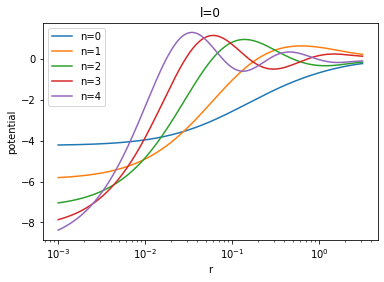

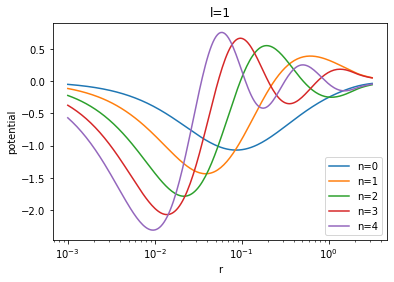

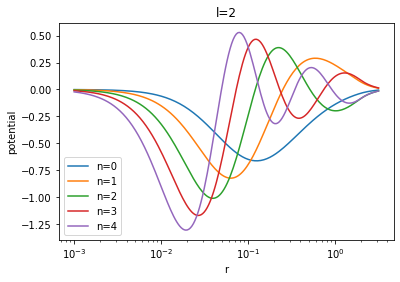

In [7]:
# Make a logarithmically space grid in radius
#
r = np.linspace(lrmin, lrmax, rnum)
r = np.power(10.0, r)

for l in range(3):
    for n in range(5):
        plt.semilogx(r, halo_grid[l][n]['potential'], '-', label="n={}".format(n))
    plt.xlabel('r')
    plt.ylabel('potential')
    plt.title('l={}'.format(l))
    plt.legend()
    plt.show()
  

The cylindrical basis are two-dimensional merional planes.   We'll use `contourf` for those.

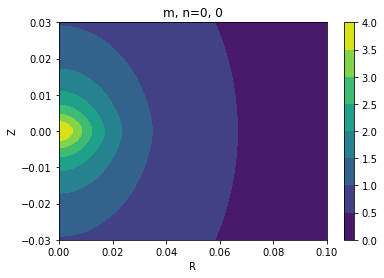

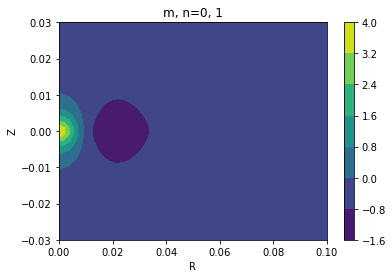

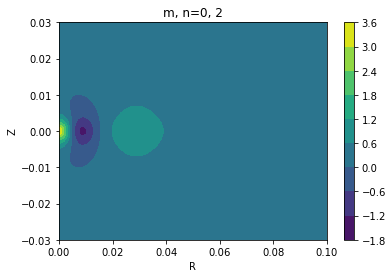

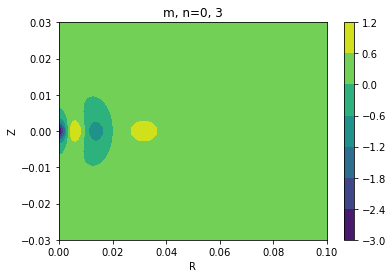

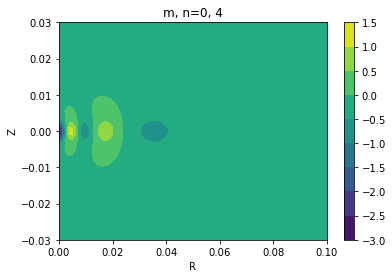

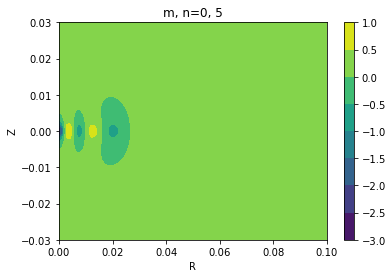

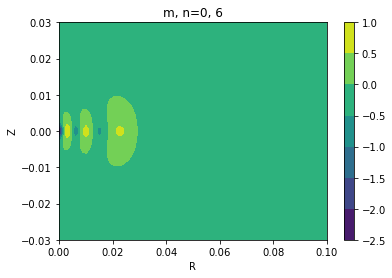

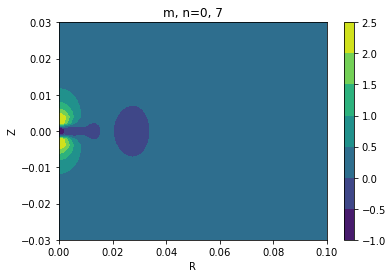

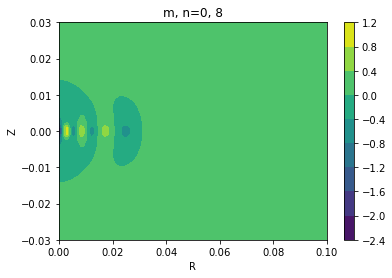

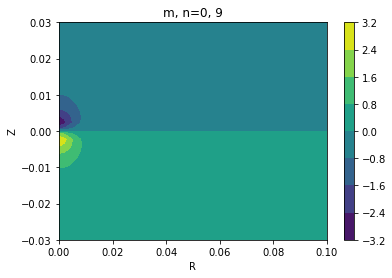

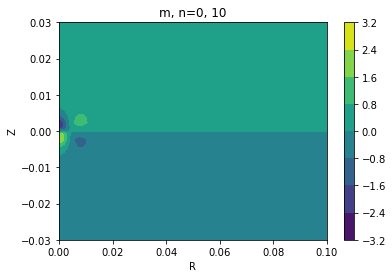

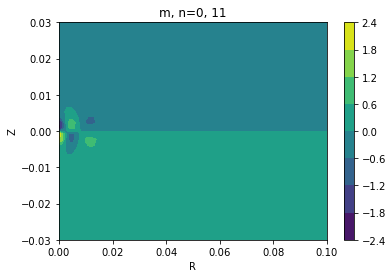

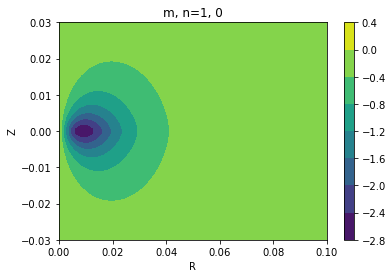

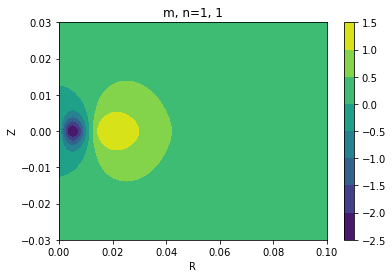

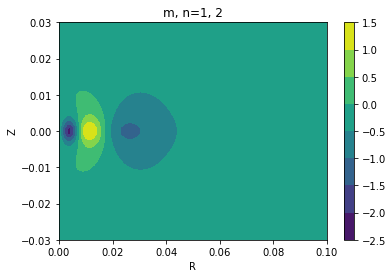

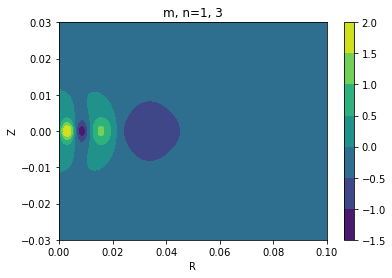

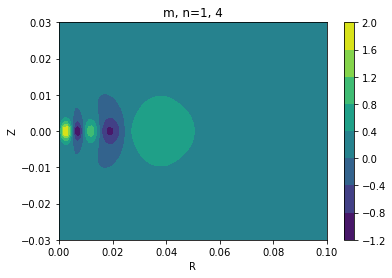

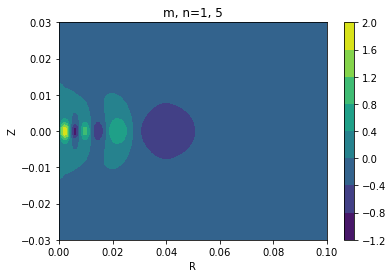

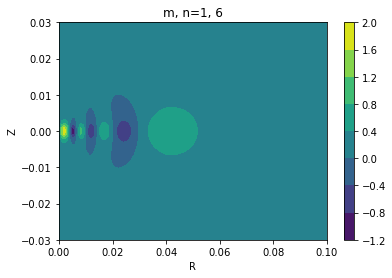

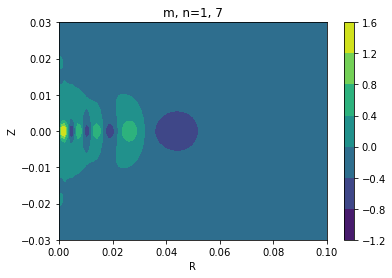

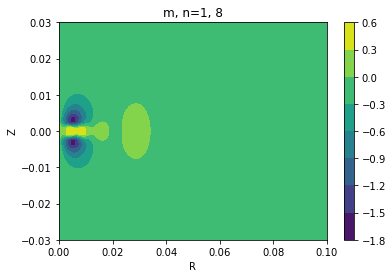

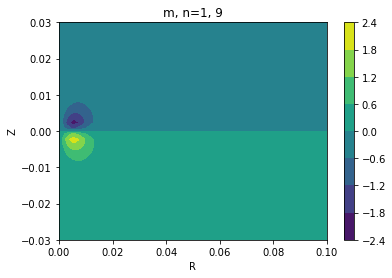

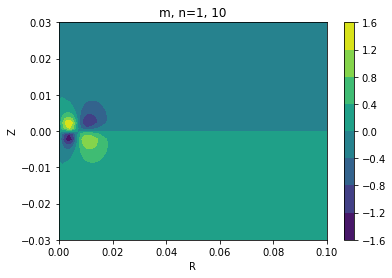

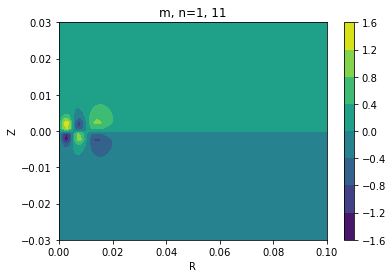

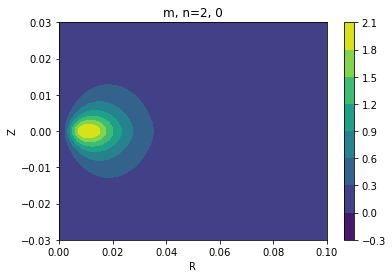

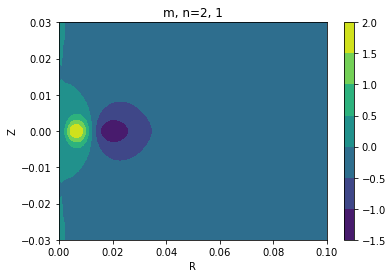

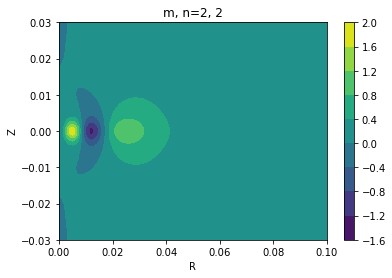

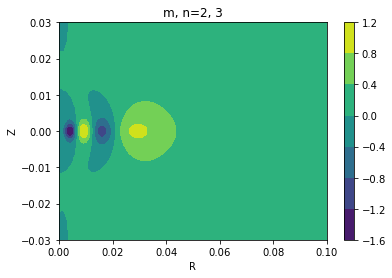

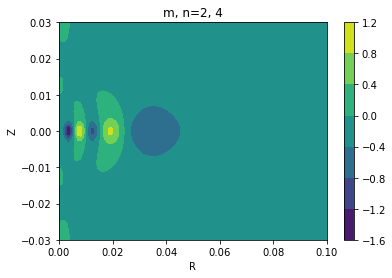

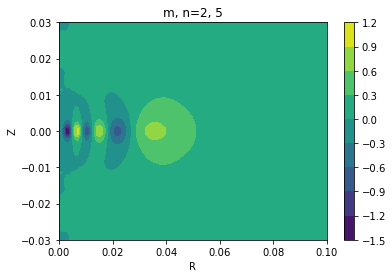

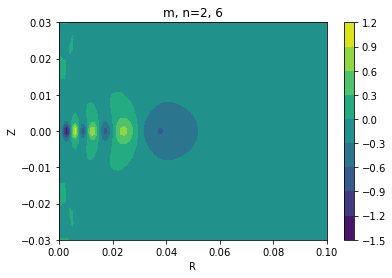

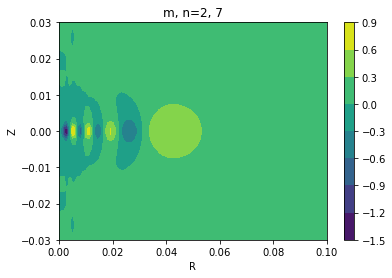

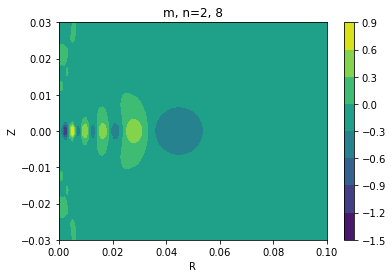

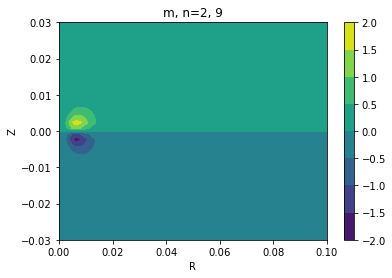

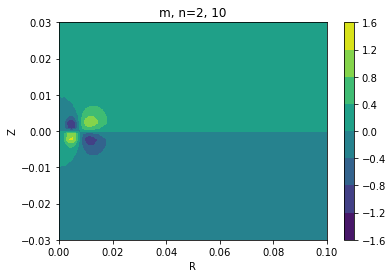

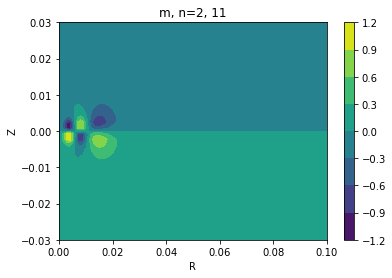

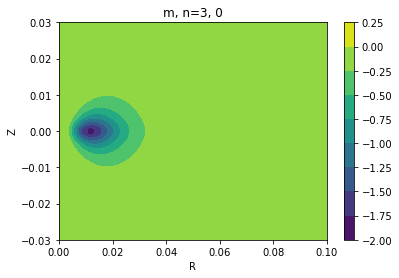

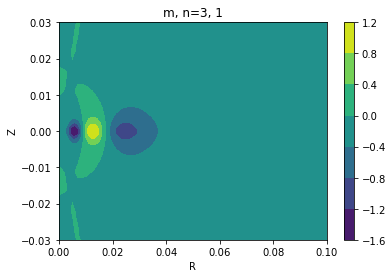

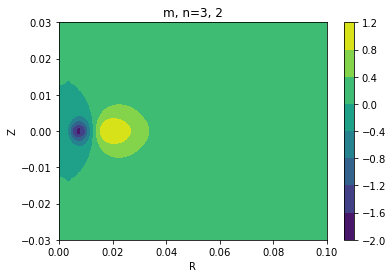

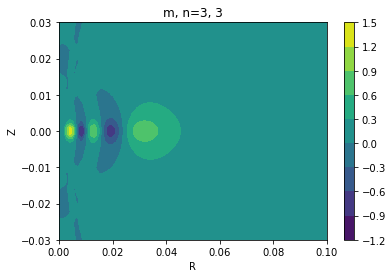

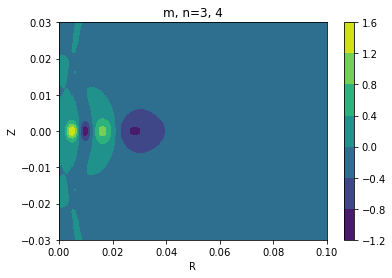

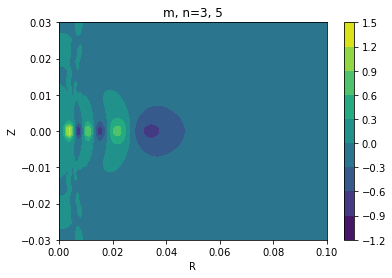

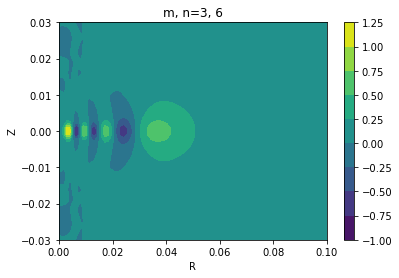

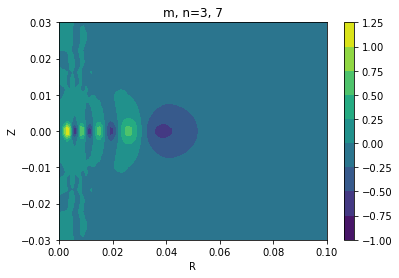

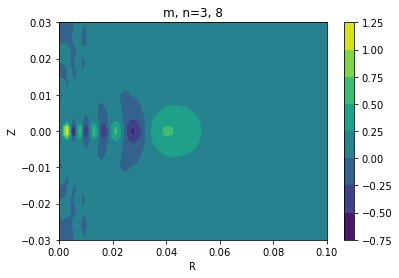

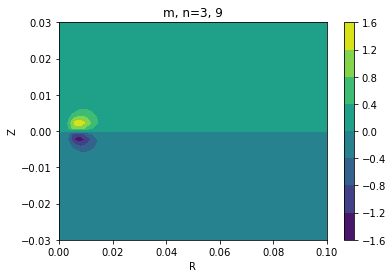

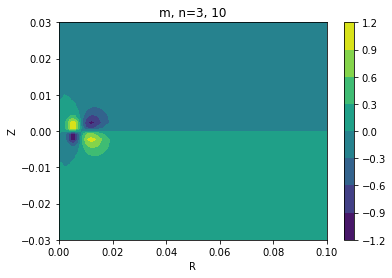

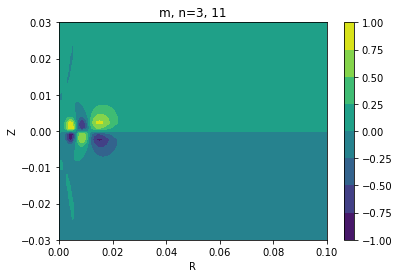

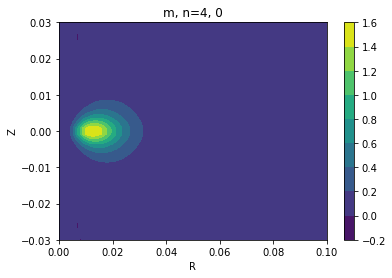

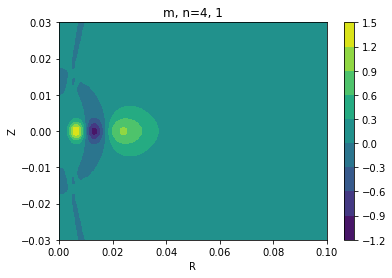

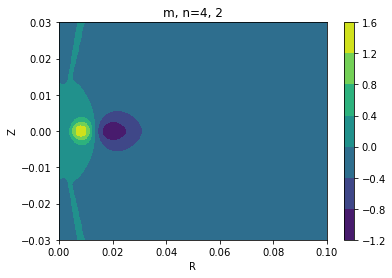

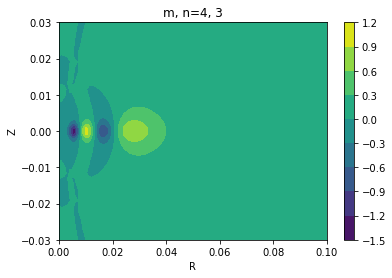

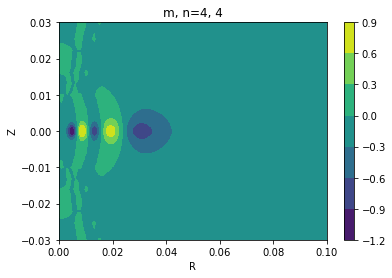

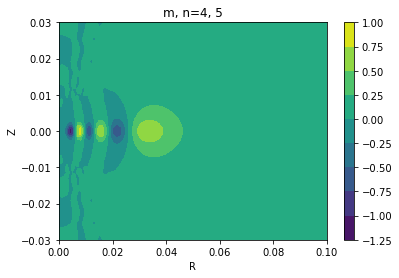

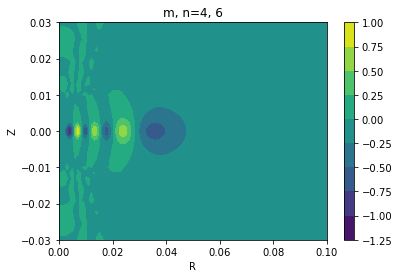

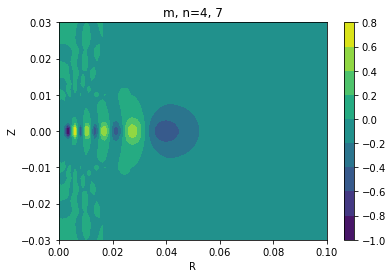

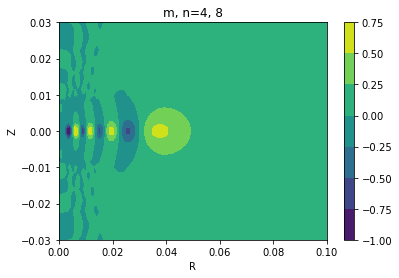

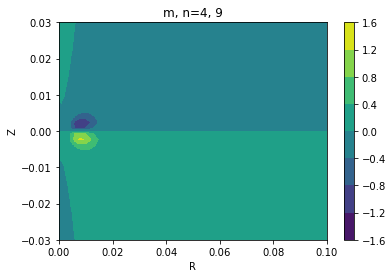

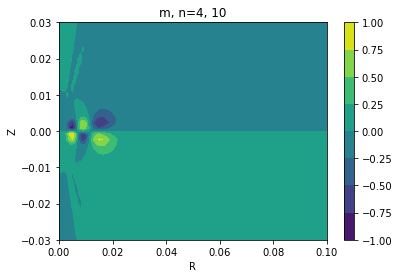

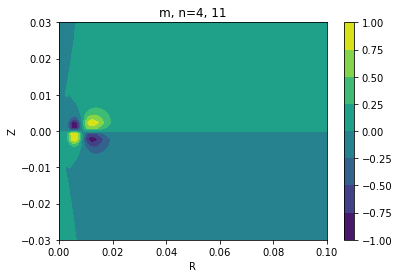

In [8]:
  
R = np.linspace(Rmin, Rmax, Rnum)
Z = np.linspace(Zmin, Zmax, Znum)

xv, yv = np.meshgrid(R, Z)

for m in range(5):
    for n in range(12):
        # Tranpose for contourf
        cx = plt.contourf(xv, yv, disk_grid[m][n]['potential'].transpose())
        plt.xlabel('R')
        plt.ylabel('Z')
        plt.title('m, n={}, {}'.format(m, n))
        plt.colorbar(cx)
        plt.show()
    